# 2D Hyperparameter Tuning for HDBSCAN

Description

In [1]:
# Reload the notebook if an external file is updated
%load_ext autoreload
%autoreload 2

import sys

from pathlib import Path

path = str(Path.cwd().parent)
sys.path.append(path)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from constant import TUNING
from datatype.dataset import Dataset
from datatype.scatter import Scatter, TwoDimensional
from datatype.trace import HDBScanTrace
from sklearn.metrics import (
    calinski_harabasz_score, 
    make_scorer, 
    silhouette_score,
    davies_bouldin_score
)
from sklearn.model_selection import ParameterGrid
from datatype.spectrogram import flatten
from hdbscan import HDBSCAN
from IPython.display import display
from umap import UMAP

In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
TUNING.mkdir(parents=True, exist_ok=True)

In [5]:
dataset = Dataset('segment')
dataframe = dataset.load()

In [6]:
spectrogram = dataframe['scale'].tolist()
flattened = flatten(spectrogram)

In [7]:
um = UMAP(
    low_memory=True,
    metric='euclidean',
    min_dist=0.0,
    n_neighbors=5,
    n_components=2,
    n_jobs=-1
)

In [8]:
embedding = um.fit_transform(flattened)

In [9]:
coordinates = (
    dataframe.umap_x_2d, 
    dataframe.umap_y_2d
)

embedding = np.column_stack(coordinates)

**Calinski-Harabasz score**
* This score measures the ratio of the between-cluster dispersion and the within-cluster dispersion. 
* A higher score indicates better-defined clusters with greater separation between them. 
* It is a good measure of cluster compactness and separation.

**Davies-Bouldin score**
* This score measures the average similarity between each cluster and its most similar cluster. 
* A lower score indicates better separation between the clusters. 
* It is a good measure of cluster separation and compactness.

**Density-Based Clustering Validation (DBCV)**
* This score measures the quality of a clustering algorithm by evaluating the clusters' density. 
* A higher DBCV score indicates better clustering quality. 
* DBCV can be used to determine the best value for the parameter that controls the clustering's radius or neighborhood size.
* This score might not be an objective measure of the goodness of clusterering. 
* It may only be used to compare results across different choices of hyperparameters, therefore is only a relative score.

**Silhouette score**
* This score measures the average difference between the distance of each point to the points in its own cluster and the distance to the points in the next nearest cluster. 
* A higher score indicates better-defined clusters with greater separation between them. 
* It is a good measure of cluster separation and compactness.

In [10]:
# Generate possible combinations of hyperparameters from the ParameterGrid
grid = ParameterGrid(
    {
        'cluster_selection_method' : ['eom', 'leaf'],
        'min_cluster_size':[i for i in range(100, 1000, 100)],  
        'min_samples': [i for i in range(10, 100, 10)]
    }
)

grid = list(grid)
total = len(grid)

results = []

for index, hyperparameters in enumerate(grid, 0):
    print(f"Processing: {index}/{total}")
    
    template = {}
    
    model = HDBSCAN(
        **hyperparameters, 
        gen_min_span_tree=True
    )
    
    model.fit(embedding)
    
    labels = model.labels_
    n_clusters = set(labels)
    
    if len(n_clusters) > 1:        
        dbcvs = model.relative_validity_
        chs = calinski_harabasz_score(embedding, labels)
        dbs = davies_bouldin_score(embedding, labels)
        ss = silhouette_score(embedding, labels)

        template['n_clusters'] = n_clusters
        template['hyperparameters'] = hyperparameters
        
        # A fast approximation of the Density Based Cluster Validity (DBCV) score
        template['density_based_cluster_validity_score'] = dbcvs
        template['calinski_harabasz_score'] = chs
        
        # The following do not account for noise
        template['davies_bouldin_score'] = dbs
        template['silhouette_score'] = ss

        results.append(template)

Processing: 0/162
Processing: 1/162
Processing: 2/162
Processing: 3/162
Processing: 4/162
Processing: 5/162
Processing: 6/162
Processing: 7/162
Processing: 8/162
Processing: 9/162
Processing: 10/162
Processing: 11/162
Processing: 12/162
Processing: 13/162
Processing: 14/162
Processing: 15/162
Processing: 16/162
Processing: 17/162
Processing: 18/162
Processing: 19/162
Processing: 20/162
Processing: 21/162
Processing: 22/162
Processing: 23/162
Processing: 24/162
Processing: 25/162
Processing: 26/162
Processing: 27/162
Processing: 28/162
Processing: 29/162
Processing: 30/162
Processing: 31/162
Processing: 32/162
Processing: 33/162
Processing: 34/162
Processing: 35/162
Processing: 36/162
Processing: 37/162
Processing: 38/162
Processing: 39/162
Processing: 40/162
Processing: 41/162
Processing: 42/162
Processing: 43/162
Processing: 44/162
Processing: 45/162
Processing: 46/162
Processing: 47/162
Processing: 48/162
Processing: 49/162
Processing: 50/162
Processing: 51/162
Processing: 52/162
Pro

In [11]:
scoring = pd.DataFrame.from_dict(results)

In [12]:
scores = [
    'density_based_cluster_validity_score',
    'calinski_harabasz_score', 
    'davies_bouldin_score', 
    'silhouette_score'
]

scoring.sort_values(
    scores, 
    ascending=[False, True, False, False], 
    inplace=True
)

In [13]:
path = TUNING.joinpath('scoring_hdbscan_2d.xlsx')
scoring.to_excel(path, sheet_name='scoring_hdbscan_2d')

path = TUNING.joinpath('scoring_hdbscan_2d.html')
scoring.to_html(path)

In [14]:
scoring.head(1)

,n_clusters,hyperparameters,density_based_cluster_validity_score,calinski_harabasz_score,davies_bouldin_score,silhouette_score
31,"{0, 1, 2, 3, 4, 5, -1}","{'cluster_selection_method': 'eom', 'min_cluster_size': 400, 'min_samples': 50}",0.606122,2152.679188,1.816187,0.115586


In [15]:
best = scoring.head(1)

In [16]:
hyperparameters = best.hyperparameters.squeeze()

cluster_selection_method = hyperparameters.get('cluster_selection_method')
min_cluster_size = hyperparameters.get('min_cluster_size')
min_samples = hyperparameters.get('min_samples')

cluster = HDBSCAN(
    cluster_selection_method=cluster_selection_method,
    core_dist_n_jobs=6,
    gen_min_span_tree=True,
    min_cluster_size=min_cluster_size,
    min_samples=min_samples,
).fit(embedding)

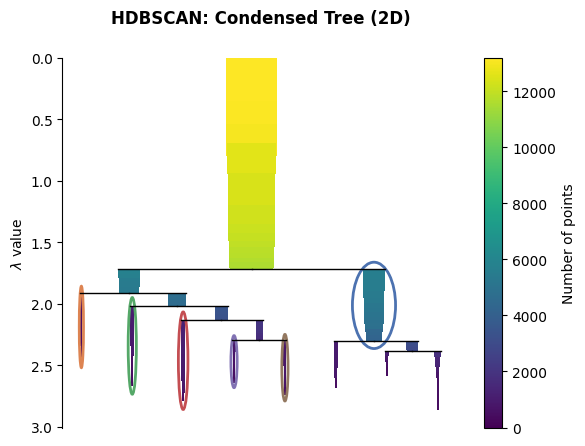

In [17]:
# Condensed tree
selection_palette = sns.color_palette('deep', min_cluster_size)

cluster.condensed_tree_.plot(
    select_clusters=True,
    selection_palette=selection_palette
)

file = TUNING.joinpath('hdbscan_condensed_tree_2d.png')

plt.title(
    'HDBSCAN: Condensed Tree (2D)',
    fontweight=600,
    fontsize=12,
    pad=25
)

plt.savefig(
    file,
    bbox_inches='tight',
    dpi=300,
    format='png'
)

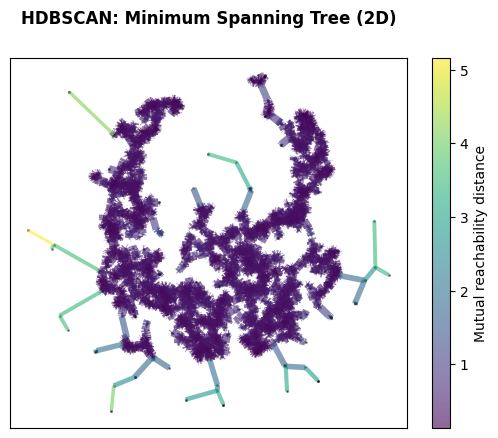

In [18]:
# Minimum spanning tree
cluster.minimum_spanning_tree_.plot(
    edge_alpha=0.6,
    edge_cmap='viridis',
    edge_linewidth=2,
    node_alpha=0.1,
    node_size=1.0
)

file = TUNING.joinpath('hdbscan_minimum_spanning_tree_2d.png')

plt.title(
    'HDBSCAN: Minimum Spanning Tree (2D)',
    fontweight=600,
    fontsize=12,
    pad=25
)

plt.savefig(
    file,
    bbox_inches='tight',
    dpi=300,
    format='png'
)

In [ ]:
# # Single linkage tree
# cluster.single_linkage_tree_.plot()

# file = TUNING.joinpath('hdbscan_single_linkage_tree_2d.png')

# plt.title(
#     'HDBSCAN: Single Linkage Tree (2D)',
#     fontweight=600,
#     fontsize=12,
#     pad=25
# )

# plt.savefig(
#     file,
#     bbox_inches='tight',
#     dpi=300,
#     format='png'
# )

In [ ]:
dataframe['hdbscan_label_2d'] = cluster.labels_

In [ ]:
strategy = TwoDimensional(dataframe)
strategy.trace = HDBScanTrace()

scatter = Scatter(dataframe)
scatter.strategy = strategy
scatter.create()

plot = scatter.get_plot()
display(plot)